# Imports

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from boruta import BorutaPy
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedShuffleSplit

from sklearn.feature_selection import VarianceThreshold, f_classif, SelectKBest, RFECV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import f1_score, roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset

In [2]:
dados = pd.read_csv('Dados/Tratado-csv/1v0.csv',header=0,index_col=0)
dados.index.name='Probes'
ae = pd.read_csv('Dados/Tratado-csv/AdverseEvent.csv',index_col=0)
ar = pd.read_csv('Dados/Tratado-csv/AntibodyResponse.csv',index_col=0)
dados = pd.concat([dados,ae,ar],axis=1)
dados = dados.dropna(how='any',axis=0)
X = dados.drop(dados.columns[-2:],axis=1)
genes = np.array(X.columns)
y_ae = dados[dados.columns[-2]]
y_ar = dados[dados.columns[-1]]
X.head()

,MARC1,MARCH1,MARC2,MARCH2,MARCH3,MARCH5,MARCH6,MARCH7,MARCH8,MARCH9,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
G305,0.242012,0.160667,0.334218,0.128834,0.423837,0.383878,0.549269,0.118496,0.265228,1.000000,...,0.200853,0.196095,0.417100,0.313864,0.431619,0.716832,0.726968,0.589935,0.557249,0.697976
G102,0.097947,0.969388,0.057645,0.292160,0.011729,0.280620,0.277724,0.613370,0.154169,0.355240,...,0.569036,0.114953,0.294043,0.303472,0.753035,0.215427,0.419179,0.295388,0.592959,0.307296
G120,0.175804,0.499479,0.462908,0.152632,0.256344,0.894201,0.533709,0.950390,0.205718,0.200807,...,0.301122,0.367244,0.110495,0.252498,0.546039,0.275148,0.820298,0.629097,0.392440,0.234136
G105,0.208543,0.182351,0.062311,0.179667,0.248777,0.105611,0.366059,0.161228,0.173616,0.749766,...,0.169052,0.000000,0.528351,0.371722,0.956183,0.562884,0.051608,0.564213,0.099206,1.000000
G304,0.105972,0.767500,0.037707,0.189626,0.406686,0.557530,0.220183,0.421494,0.377251,0.226414,...,0.120617,0.295468,0.522655,0.145206,0.185419,0.392535,0.338361,0.305716,0.620625,0.292157


# Analyse variance

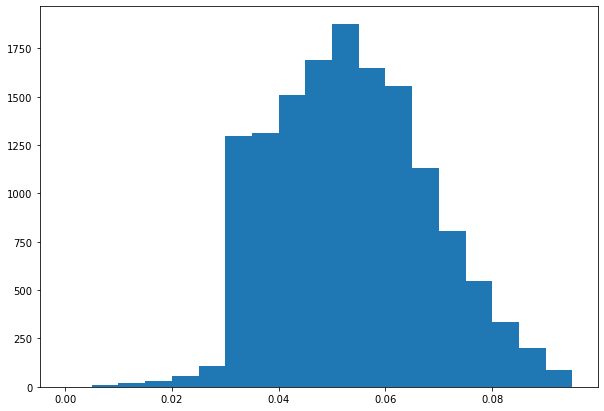

In [3]:
var=[]
for col in X.columns:
    var.append(X[col].var())
interval = 0.005
size = 20
bins = [i*interval for i in range(size)]
fig, ax = plt.subplots(figsize =(10, 7)) 
ax.hist(var,bins = bins);

## Remove lines probes with `var` < `treshold`

In [4]:
treshold = 5e-2
print(X.shape)
selector = VarianceThreshold(treshold)
X = selector.fit_transform(X)
print(X.shape)
index = np.where(selector.get_support()==True)
X = pd.DataFrame(X)
X.columns = genes[index]
X.head()

(30, 14279)
(30, 7565)


,MARCH1,MARC2,MARCH2,MARCH3,MARCH5,MARCH7,MARCH9,SEPT1,SEPT5,SEPT6,...,ZSCAN30,ZSWIM3,ZSWIM6,ZUFSP,ZW10,ZWINT,ZXDB,ZXDC,ZYX,ZZZ3
0,0.160667,0.334218,0.128834,0.423837,0.383878,0.118496,1.000000,0.374424,0.364903,0.243756,...,0.718769,0.238057,0.280264,0.000000,0.200853,0.417100,0.431619,0.716832,0.589935,0.697976
1,0.969388,0.057645,0.292160,0.011729,0.280620,0.613370,0.355240,0.584297,0.190682,0.393642,...,0.122696,0.649423,0.777812,0.175056,0.569036,0.294043,0.753035,0.215427,0.295388,0.307296
2,0.499479,0.462908,0.152632,0.256344,0.894201,0.950390,0.200807,0.685460,0.391286,0.552908,...,0.868514,1.000000,0.277317,0.332328,0.301122,0.110495,0.546039,0.275148,0.629097,0.234136
3,0.182351,0.062311,0.179667,0.248777,0.105611,0.161228,0.749766,0.592156,0.614202,0.642848,...,0.228498,0.286919,0.258031,0.044801,0.169052,0.528351,0.956183,0.562884,0.564213,1.000000
4,0.767500,0.037707,0.189626,0.406686,0.557530,0.421494,0.226414,0.292800,0.420510,0.271168,...,0.120668,0.408151,0.318812,0.177021,0.120617,0.522655,0.185419,0.392535,0.305716,0.292157


# Adverse Event

## Feature Selection

### Boruta

In [5]:
X_ae = X

forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=15)
forest.fit(np.array(X_ae), np.array(y_ae).ravel())
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=42)
feat_selector.fit(np.array(X_ae), np.array(y_ae).ravel())
feature_ranks_ae = list(zip(X_ae.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

features_ae = []
for feat in feature_ranks_ae:
    if feat[2]:
        features_ae.append(feat[0])
X_ae = X_ae[features_ae]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	7557
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	7557
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	7557
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	7557
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	7557
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	7557
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	7557
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	7557
Iteration: 	16 / 100
Confirmed: 	0

### ANOVA

In [69]:
X_ae = X
anova =  SelectKBest(f_classif, k=100).fit(X_ae, y_ae)
X_ae = pd.DataFrame(anova.fit_transform(X_ae,y_ae))
index = np.where(anova.get_support()==True)
X_ae.columns = genes[index]
X_ae.head()

,AAMDC,ABO,ACYP2,ALKBH3,AP4B1,APAF1,APPBP2,ARAP3,ARHGAP23,ARHGAP5,...,LOC286367,LOC389906,LOC441454,LY86,LYSMD1,MAML1,MANEAL,MAP3K8,MATK,MBD2
0,0.341546,0.039805,0.631672,0.506658,0.467282,0.863378,0.261259,0.113562,0.060405,0.243100,...,1.000000,0.030421,0.123071,0.950796,0.560368,0.855394,0.297311,0.365958,0.179749,0.741572
1,0.010585,0.107631,0.429177,0.521714,0.391022,0.937715,0.375626,0.136572,0.197362,0.125542,...,0.551249,0.074359,0.000000,1.000000,0.100688,0.369743,0.272301,0.312025,0.395705,0.298790
2,0.232293,0.122255,0.628704,0.247820,0.157624,0.048185,0.170937,0.332689,0.086236,0.452498,...,0.211813,0.275251,0.297463,0.525898,0.818862,0.542641,0.193587,0.241475,0.243461,0.156616
3,0.146955,0.156305,0.861992,0.410327,0.670866,0.401760,0.510160,0.500556,0.190013,0.331652,...,0.531715,0.237656,0.397096,0.192013,0.077470,1.000000,0.036865,0.356986,0.044421,0.525299
4,0.102039,0.246682,0.569008,0.183832,0.439132,0.435561,0.610962,0.135712,0.238244,0.100378,...,0.170504,0.265218,0.274594,0.371275,0.231626,0.674535,0.012607,0.313410,0.184295,0.433874


# Balance dataframe

In [6]:
sm = SMOTE(random_state=42)
X_ae, y_ae = sm.fit_resample(X_ae, y_ae)
y_ae = pd.DataFrame(y_ae)
X_ae.shape

(42, 6)

# Machine Learning 

## Hyperparameter tuning

In [7]:
def get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid, model,w=None,h=None,df=None,plot=None,annot=None):
    
    gs = GridSearchCV(estimator=model,
                      param_grid=param_grid,
                      cv=kfold)
    best_gs = gs.fit(X_train,y_train)
    n = len(param_grid)
    scores = best_gs.cv_results_['mean_test_score']
    scores = scores.reshape(len(scores),)
    
    if n == 1 and plot:
        label = list(param_grid.keys())[0]
        par = list(param_grid.values())[0]
        plt.plot(par,scores)
        plt.ylabel('F1-score')
        plt.xlabel(label)
        plt.show()
        
    if n == 2 and plot:
        
        label1,label2 = param_grid.keys()
        par1,par2 = param_grid.values()
        scores_df = pd.DataFrame(columns=par1,index=par2)
        for i in range(len(par1)*len(par2)):
            col = i % len(par1)
            row = i // len(par1)
            scores_df.iloc[row,col] = scores[i]

        scores_df = scores_df.astype(float)
        if df:
            print(scores_df)
        if plot:
            fig= plt.figure(figsize=(w,h))
            heatmap = sns.heatmap(scores_df,annot=annot)        
            plt.xlabel(label1)
            plt.ylabel(label2)
            plt.show()

    return best_gs.best_params_


## Algorithm

In [8]:
n_splits = 5
test_size = 0.3
n_folds = 5
kfold = KFold(n_folds,shuffle=True,random_state=42)
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

#Decision Trees
param_grid_tree = {'max_depth':[1,2,3,4,5],
                   'criterion':['gini','entropy']
                  }

#KNN
param_grid_knn = {'n_neighbors':[1,2,3,4,5],
                  'algorithm':['auto','ball_tree','kd_tree','brute']
                 }

#Random Forest
param_grid_rf = {'n_estimators':[150,158,166,174,182]}

#SGD
param_grid_sgd = {'loss':['hinge', 'perceptron'],
                 'penalty':['l2', 'l1', 'elasticnet'],
                 'alpha':[1e-5,1e-4,1e-3,1e-2,1e-1]
                 }

#SVC
param_grid_svc = {'C':[1, 5, 10, 50, 100,],
                  'gamma':['scale','auto']
                 }

tree_score= .0
knn_score= .0
rf_score= .0
sgd_score= .0
svc_score=.0

rounds = 0

for train_index, test_index in sss.split(X_ae, y_ae):
    print(f'Round {rounds+1}:')
    X_train,X_test,y_train,y_test = X_ae.iloc[train_index],X_ae.iloc[test_index],y_ae.iloc[train_index],y_ae.iloc[test_index]
    
    #Decision trees
    hp_tree= get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid_tree,DecisionTreeClassifier(random_state=42))
    criterion_opt,max_depth_opt = hp_tree.values()
    print(f'Trees: max_depth={max_depth_opt}, criterion={criterion_opt}')
    tree = make_pipeline(StandardScaler(),
                         DecisionTreeClassifier(
                            random_state=42,
                            criterion=criterion_opt,
                            max_depth=max_depth_opt,
                         )
                        )
    tree.fit(X_train,y_train)
    pred_tree = tree.predict(X_test)
    f1_tree = round(f1_score(y_test,pred_tree),2)
    tree_score += f1_tree
    
    #KNN
    hp_knn = get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid_knn,KNeighborsClassifier())
    algorithm_opt,n_neighbors_opt = hp_knn.values()
    print(f'KNN: n_neighbors={n_neighbors_opt}, algorithm={algorithm_opt}')
    knn = make_pipeline(StandardScaler(),
                        KNeighborsClassifier(
                            n_neighbors=n_neighbors_opt,
                            algorithm=algorithm_opt
                        )
                       )
    knn.fit(X_train,y_train)
    pred_knn = knn.predict(X_test)
    f1_knn = round(f1_score(y_test,pred_knn),2)
    knn_score += f1_knn
    
    #Random Forest
    hp_rf = get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid_rf,RandomForestClassifier())
    n_estimators_opt = list(hp_rf.values())[0]
    print(f'RF: n_estimators={n_estimators_opt}')
    rf = make_pipeline(StandardScaler(),
                        RandomForestClassifier(
                            n_estimators=n_estimators_opt
                        )
                       )
    rf.fit(X_train,y_train)
    pred_rf = rf.predict(X_test)
    f1_rf = round(f1_score(y_test,pred_rf),2)
    rf_score += f1_rf
    
    #SGD
    hp_sgd = get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid_sgd,SGDClassifier())
    alpha_opt,loss_opt,penalty_opt = hp_sgd.values()
    print(f'SGD: loss={loss_opt}, alpha={alpha_opt}, penalty={penalty_opt}')
    sgd = make_pipeline(StandardScaler(),
                        SGDClassifier(
                            loss=loss_opt,
                            alpha=alpha_opt,
                            penalty=penalty_opt
                        )
                       )
    sgd.fit(X_train,y_train)
    pred_sgd = sgd.predict(X_test)
    f1_sgd = round(f1_score(y_test,pred_sgd),2)
    sgd_score += f1_sgd
    
    #SVC
    hp_svc = get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid_svc,SVC())
    c_opt,gamma_opt = hp_svc.values()
    print(f'SVC: C={c_opt}, gamma={gamma_opt}')
    svc = make_pipeline(StandardScaler(),
                        SVC(C=c_opt,
                            gamma=gamma_opt,
                            kernel='rbf'
                           )
                       )
    svc.fit(X_train,y_train)
    pred_svc = svc.predict(X_test)
    f1_svc = round(f1_score(y_test,pred_svc),2)
    svc_score += f1_svc
    
    print(f"\nF1 scores: Trees={f1_tree}, KNN={f1_knn}, RF={f1_rf}, SGD={f1_sgd}, SVC={f1_svc}\n")
    
    rounds += 1

print(f"\nTotal F1 scores: Trees={round(tree_score/rounds,2)}, KNN={round(knn_score/rounds,2)}, RF={round(rf_score/rounds,2)}, SGD={round(sgd_score/rounds,2)}, SVC = {round(svc_score/rounds,2)}\n")

Round 1:
Trees: max_depth=3, criterion=gini
KNN: n_neighbors=1, algorithm=auto
RF: n_estimators=150
SGD: loss=hinge, alpha=0.0001, penalty=l2
SVC: C=1, gamma=scale

F1 scores: Trees=0.83, KNN=0.83, RF=0.91, SGD=0.83, SVC=0.91

Round 2:
Trees: max_depth=2, criterion=gini
KNN: n_neighbors=2, algorithm=auto
RF: n_estimators=150
SGD: loss=hinge, alpha=1e-05, penalty=l2
SVC: C=1, gamma=scale

F1 scores: Trees=0.8, KNN=0.83, RF=0.73, SGD=0.91, SVC=0.83

Round 3:
Trees: max_depth=2, criterion=gini
KNN: n_neighbors=2, algorithm=auto
RF: n_estimators=158
SGD: loss=hinge, alpha=1e-05, penalty=l2
SVC: C=1, gamma=scale

F1 scores: Trees=0.93, KNN=1.0, RF=1.0, SGD=1.0, SVC=1.0

Round 4:
Trees: max_depth=3, criterion=gini
KNN: n_neighbors=1, algorithm=auto
RF: n_estimators=150
SGD: loss=perceptron, alpha=0.001, penalty=l1
SVC: C=5, gamma=scale

F1 scores: Trees=0.83, KNN=0.91, RF=0.91, SGD=0.83, SVC=0.91

Round 5:
Trees: max_depth=1, criterion=gini
KNN: n_neighbors=1, algorithm=auto
RF: n_estimators

# Antobody Response

## Feature Selection

### Boruta

In [9]:
X_ar = X

forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=15)
forest.fit(np.array(X_ar), np.array(y_ar).ravel())
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=42)
feat_selector.fit(np.array(X_ar), np.array(y_ar).ravel())
feature_ranks_ar = list(zip(X_ar.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

features_ar = []
for feat in feature_ranks_ar:
    if feat[2]:
        features_ar.append(feat[0])
X_ar = X_ar[features_ar]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	7565
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	7548
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	7548
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	7548
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	7548
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	7550
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	7550
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	7550
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	7550
Iteration: 	16 / 100
Confi

### ANOVA

In [131]:
X_ar = X
anova =  SelectKBest(f_classif, k=100).fit(X_ar, y_ar)
X_ar = pd.DataFrame(anova.fit_transform(X_ar,y_ar))
index = np.where(anova.get_support()==True)
X_ar.columns = genes[index]
X_ar

,ACP2,ADAP2,ADPRH,ANAPC1,ANKS6,ANO10,ANXA4,ARMC2,ATP1B3,BCRP3,...,ULK4,VAMP5,WDR52,XKRX,ZFYVE1,ZNF398,ZNF514,ZNF585A,ZNF714,ZNF860
0,0.216143,0.010809,0.259041,0.612129,1.000000,0.417700,0.142284,1.000000,0.185576,0.673869,...,0.595176,0.000000,0.497873,0.279551,0.209463,0.663312,0.784719,0.455902,0.865989,0.737856
1,0.788707,0.553989,0.306159,0.483360,0.385593,0.391554,0.402197,0.413500,0.429520,0.725276,...,0.476914,0.295633,0.906812,0.203325,0.341118,1.000000,0.777085,0.156417,0.509315,0.761494
2,0.216055,0.094997,0.096638,0.720127,0.366089,0.782021,0.107275,0.381808,0.275145,0.661197,...,1.000000,0.127626,0.514514,0.425557,0.117262,0.683459,0.737132,0.149820,0.941905,0.345608
3,0.187467,0.480658,0.237734,0.244861,0.347262,0.045505,0.000000,0.669116,0.061770,1.000000,...,0.442097,0.156629,1.000000,0.072125,0.128178,0.653650,0.675559,0.195768,0.312223,1.000000
4,0.245851,0.327142,0.346874,0.628496,0.261738,0.812663,0.407584,0.324182,0.243868,0.495378,...,0.387003,0.347763,0.534417,0.367324,0.195487,0.630931,0.700004,0.424789,0.532638,0.626687
5,0.233488,0.321206,0.395521,0.409838,0.396621,0.795572,0.479224,0.416163,0.472171,0.596509,...,0.214242,0.282070,0.259378,0.370796,0.224232,0.583481,0.588801,0.387055,0.743491,0.440002
6,0.284495,0.436058,0.506817,0.529429,0.300965,0.175936,0.276953,0.483522,0.467890,0.839591,...,0.410412,0.426324,0.242134,0.440611,0.237409,0.565331,1.000000,0.231940,0.348611,0.346076
7,0.554287,0.330217,0.477923,0.520196,0.150200,0.205285,0.315097,0.090564,0.507282,0.416023,...,0.608063,0.531736,0.419974,0.250655,0.334245,0.439786,0.588235,0.202911,0.470317,0.230329
8,0.000000,0.000000,0.000000,0.797201,0.786282,1.000000,0.074137,0.615539,0.000000,0.633228,...,0.827404,0.069521,0.863775,0.534817,0.062558,0.590323,0.706546,0.208376,0.574692,0.619543
9,0.309929,0.901286,0.290444,0.506823,0.351747,0.192963,0.293003,0.992037,0.620429,0.682720,...,0.655056,0.393386,0.418158,0.190934,0.000000,0.489851,0.701334,0.303695,0.391274,0.336442


## Algorithm

In [10]:
n_splits = 5
test_size = 0.3
n_folds = 5
kfold = KFold(n_folds,shuffle=True,random_state=42)
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

#Decision Trees
param_grid_tree = {'max_depth':[1,2,3,4,5],
                   'criterion':['gini','entropy']
                  }

#KNN
param_grid_knn = {'n_neighbors':[1,2,3,4,5],
                  'algorithm':['auto','ball_tree','kd_tree','brute']
                 }

#Random Forest
param_grid_rf = {'n_estimators':[150,158,166,174,182]}

#SGD
param_grid_sgd = {'loss':['hinge', 'perceptron'],
                 'penalty':['l2', 'l1', 'elasticnet'],
                 'alpha':[1e-5,1e-4,1e-3,1e-2,1e-1]
                 }

#SVC
param_grid_svc = {'C':[1, 5, 10, 50, 100,],
                  'gamma':['scale','auto']
                 }

rounds = 0

for train_index, test_index in sss.split(X_ar, y_ar):
    print(f'Round {rounds+1}:')
    X_train,X_test,y_train,y_test = X_ar.iloc[train_index],X_ar.iloc[test_index],y_ar.iloc[train_index],y_ar.iloc[test_index]
    
    #Decision trees
    hp_tree= get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid_tree,DecisionTreeClassifier(random_state=42))
    criterion_opt,max_depth_opt = hp_tree.values()
    print(f'Trees: max_depth={max_depth_opt}, criterion={criterion_opt}')
    tree = make_pipeline(StandardScaler(),
                         DecisionTreeClassifier(
                            random_state=42,
                            criterion=criterion_opt,
                            max_depth=max_depth_opt,
                         )
                        )
    tree.fit(X_train,y_train)
    pred_tree = tree.predict(X_test)
    f1_tree = round(f1_score(y_test,pred_tree),2)
    tree_score += f1_tree
    
    #KNN
    hp_knn = get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid_knn,KNeighborsClassifier())
    algorithm_opt,n_neighbors_opt = hp_knn.values()
    print(f'KNN: n_neighbors={n_neighbors_opt}, algorithm={algorithm_opt}')
    knn = make_pipeline(StandardScaler(),
                        KNeighborsClassifier(
                            n_neighbors=n_neighbors_opt,
                            algorithm=algorithm_opt
                        )
                       )
    knn.fit(X_train,y_train)
    pred_knn = knn.predict(X_test)
    f1_knn = round(f1_score(y_test,pred_knn),2)
    knn_score += f1_knn
    
    #Random Forest
    hp_rf = get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid_rf,RandomForestClassifier())
    n_estimators_opt = list(hp_rf.values())[0]
    print(f'RF: n_estimators={n_estimators_opt}')
    rf = make_pipeline(StandardScaler(),
                        RandomForestClassifier(
                            n_estimators=n_estimators_opt
                        )
                       )
    rf.fit(X_train,y_train)
    pred_rf = rf.predict(X_test)
    f1_rf = round(f1_score(y_test,pred_rf),2)
    rf_score += f1_rf
    
    #SGD
    hp_sgd = get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid_sgd,SGDClassifier())
    alpha_opt,loss_opt,penalty_opt = hp_sgd.values()
    print(f'SGD: loss={loss_opt}, alpha={alpha_opt}, penalty={penalty_opt}')
    sgd = make_pipeline(StandardScaler(),
                        SGDClassifier(
                            loss=loss_opt,
                            alpha=alpha_opt,
                            penalty=penalty_opt
                        )
                       )
    sgd.fit(X_train,y_train)
    pred_sgd = sgd.predict(X_test)
    f1_sgd = round(f1_score(y_test,pred_sgd),2)
    sgd_score += f1_sgd
    
    #SVC
    hp_svc = get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid_svc,SVC())
    c_opt,gamma_opt = hp_svc.values()
    print(f'SVC: C={c_opt}, gamma={gamma_opt}')
    svc = make_pipeline(StandardScaler(),
                        SVC(C=c_opt,
                            gamma=gamma_opt,
                            kernel='rbf'
                           )
                       )
    svc.fit(X_train,y_train)
    pred_svc = svc.predict(X_test)
    f1_svc = round(f1_score(y_test,pred_svc),2)
    svc_score += f1_svc
    
    print(f"\nF1 scores: Trees={f1_tree}, KNN={f1_knn}, RF={f1_rf}, SGD={f1_sgd}, SVC={f1_svc}\n")
    
    rounds += 1

print(f"\nTotal F1 scores: Trees={round(tree_score/rounds,2)}, KNN={round(knn_score/rounds,2)}, RF={round(rf_score/rounds,2)}, SGD={round(sgd_score/rounds,2)}, SVC = {round(svc_score/rounds,2)}\n")

Round 1:
Trees: max_depth=1, criterion=gini
KNN: n_neighbors=4, algorithm=auto
RF: n_estimators=150
SGD: loss=hinge, alpha=0.01, penalty=l2
SVC: C=5, gamma=scale

F1 scores: Trees=0.67, KNN=0.75, RF=0.8, SGD=0.75, SVC=0.75

Round 2:
Trees: max_depth=2, criterion=gini
KNN: n_neighbors=1, algorithm=auto
RF: n_estimators=150
SGD: loss=perceptron, alpha=0.0001, penalty=l2
SVC: C=1, gamma=scale

F1 scores: Trees=0.67, KNN=1.0, RF=0.86, SGD=0.86, SVC=0.86

Round 3:
Trees: max_depth=1, criterion=gini
KNN: n_neighbors=1, algorithm=auto
RF: n_estimators=150
SGD: loss=perceptron, alpha=0.1, penalty=l2
SVC: C=5, gamma=scale

F1 scores: Trees=0.86, KNN=0.86, RF=1.0, SGD=1.0, SVC=1.0

Round 4:
Trees: max_depth=3, criterion=gini
KNN: n_neighbors=5, algorithm=auto
RF: n_estimators=158
SGD: loss=hinge, alpha=0.01, penalty=elasticnet
SVC: C=5, gamma=auto

F1 scores: Trees=0.57, KNN=0.67, RF=0.86, SGD=0.86, SVC=0.86

Round 5:
Trees: max_depth=1, criterion=gini
KNN: n_neighbors=3, algorithm=auto
RF: n_es